In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks')

# New section

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from TrajectoryObject import TrajectoryObj
from FileIO import write_trajectory, read_trajectory, read_mosaic, read_localization, read_andi2_trajectory_label
from andi_datasets.models_phenom import models_phenom
from andi_datasets.datasets_phenom import datasets_phenom
from andi_datasets.utils_trajectories import plot_trajs
from andi_datasets.utils_challenge import label_continuous_to_list

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2024-03-18 12:53:42.409650: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 12:53:42.847249: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/junwoo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TIME_INTERVAL = 1
NB_INPUT_FEATURES = 2
NB_LABEL_FEATURES = 1
WINDOW_WIDTH=5
SHUFFLE=True
MAX_EPOCHS = 5000
BATCH_SIZE=256
PATIENCE=250

In [3]:
N=1
T=50000
L = 1.5*128

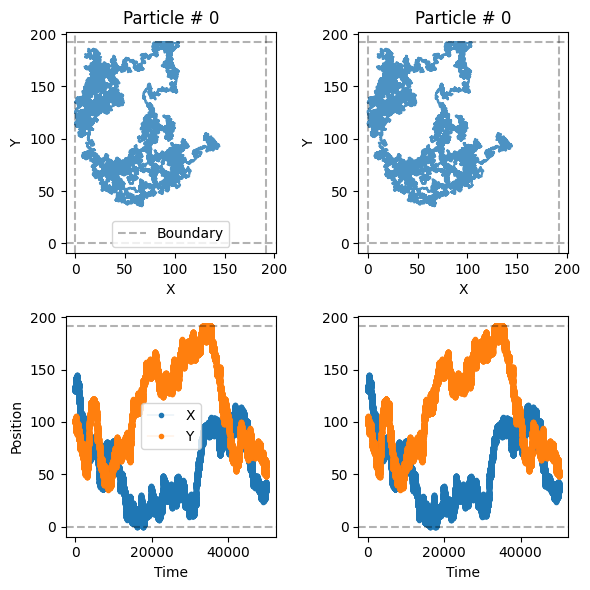

In [4]:
trajs_model, labels_model = models_phenom().multi_state(N=N,
                                                        L=L,
                                                        T=T,
                                                        alphas=[0.85, 1.15],  # Fixed alpha for each state
                                                        Ds=[[0.1, 0.0], [0.1, 0.0]],# Mean and variance of each state
                                                        M=[[0.95, 0.05], [0.05, 0.95]]
                                                       )
plot_trajs(trajs_model, L, N, num_to_plot =2)

In [5]:
changepoints, alphas, Ds, state_num = label_continuous_to_list(labels_model[:, 0, :])
print(f'change points: {changepoints}, {changepoints.shape}')
print(f'alphas: {alphas}, {alphas.shape}')
print(f'Ds: {Ds}, {Ds.shape}')
print(f'State_nums: {state_num}, {state_num.shape}')

weight_for_0 = (1 / (T-len(changepoints))) * (T / 2.0)
weight_for_1 = (1 / len(changepoints) * (T / 2.0))
CLASS_WEIGHT = {0: weight_for_0, 1: weight_for_1}
print(CLASS_WEIGHT)

change points: [    4     6    15 ... 49951 49958 50000], (2575,)
alphas: [0.85 1.15 0.85 ... 0.85 1.15 0.85], (2575,)
Ds: [0.1 0.1 0.1 ... 0.1 0.1 0.1], (2575,)
State_nums: [2. 2. 2. ... 2. 2. 2.], (2575,)
{0: 0.5271481286241434, 1: 9.708737864077671}


In [6]:
xs = trajs_model[:, 0, 0]
ys = trajs_model[:, 0, 1]
pos = np.array([xs, ys]).T
trajectory_object = TrajectoryObj(index=0)
for t, (x, y) in enumerate(pos):
    trajectory_object.add_trajectory_position(t, x, y, 0.0)
label_list = read_andi2_trajectory_label([Ds, alphas, state_num, changepoints])
trajectory_label = label_list[0]

print(xs[:10])
print(ys[:10])

[129.42991164 129.93262815 129.63601771 130.88993928 130.47690402
 129.87616536 130.38323662 129.85321379 130.08782994 130.49763703]
[ 98.89514214  98.75579475  98.94436777  98.95871422  99.49255687
  99.79249482 100.70363389 100.17955345 100.78398538 101.10418254]


In [7]:
"""
trajectory_list = read_trajectory(f'data/trajs_fov_0.csv')
label_list = read_andi2_trajectory_label(f'data/traj_labs_fov_0.txt')
trajectory_object = trajectory_list[0]
trajectory_label = label_list[0]
"""

"\ntrajectory_list = read_trajectory(f'data/trajs_fov_0.csv')\nlabel_list = read_andi2_trajectory_label(f'data/traj_labs_fov_0.txt')\ntrajectory_object = trajectory_list[0]\ntrajectory_label = label_list[0]\n"

In [8]:
diff_coefs = trajectory_object.get_diffusion_coefs(time_interval=TIME_INTERVAL)
msd = trajectory_object.get_msd(time_interval=TIME_INTERVAL)
angles = trajectory_object.get_trajectory_angles(time_interval=TIME_INTERVAL)
xs = trajectory_object.get_positions()[:,0]
ys = trajectory_object.get_positions()[:,1]

labeled_diff_coefs = trajectory_label[0]
labeled_alphas = trajectory_label[1]
labeled_states = trajectory_label[2]
labeled_cps = trajectory_label[3].astype(int)

In [9]:
print(msd.shape, diff_coefs.shape, angles.shape, xs.shape, ys.shape, labeled_diff_coefs.shape, labeled_alphas.shape, labeled_states.shape, labeled_cps.shape)

(50000,) (50000,) (50000,) (50000,) (50000,) (50000,) (50000,) (50000,) (50000,)


In [10]:
#df = np.array([xs, ys, diff_coefs, msd, angles]).T
df = np.array([xs, ys]).T
#df = pd.DataFrame(df, columns=['xs', 'ys', 'diff_coefs', 'msd', 'angles'])
df = pd.DataFrame(df, columns=['xs', 'ys'])
target_df = np.array([labeled_cps]).T  # labeled_diff_coefs, labeled_alphas, labeled_states, labeled_cps
target_df = pd.DataFrame(target_df, columns=['cps'])  # 'lb_diff_coefs', 'alphas', 'states', 'cps'

In [11]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

target_train_df = target_df[0:int(n*0.7)]
target_val_df = target_df[int(n*0.7):int(n*0.9)]
target_test_df = target_df[int(n*0.9):]

In [12]:
"""
train_mean = train_df.mean()
train_std = train_df.std()

for normallization_col in ['xs', 'ys']:
    train_df[normallization_col] = (train_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]
    val_df[normallization_col] = (val_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]
    test_df[normallization_col] = (test_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

print(train_df.head())
"""

"\ntrain_mean = train_df.mean()\ntrain_std = train_df.std()\n\nfor normallization_col in ['xs', 'ys']:\n    train_df[normallization_col] = (train_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]\n    val_df[normallization_col] = (val_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]\n    test_df[normallization_col] = (test_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]\n\ndf_std = (df - train_mean) / train_std\ndf_std = df_std.melt(var_name='Column', value_name='Normalized')\nplt.figure(figsize=(12, 6))\nax = sns.violinplot(x='Column', y='Normalized', data=df_std)\n_ = ax.set_xticklabels(df.keys(), rotation=90)\n\nprint(train_df.head())\n"

In [13]:
class WindowGenerator():
  def __init__(self, input_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               target_train_df=target_train_df, target_val_df=target_val_df,
               target_test_df=target_test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = np.array(train_df).reshape(train_df.shape[0], NB_INPUT_FEATURES)
    self.val_df = np.array(val_df).reshape(val_df.shape[0], NB_INPUT_FEATURES)
    self.test_df = np.array(test_df).reshape(test_df.shape[0], NB_INPUT_FEATURES)

    self.target_train_df = np.zeros((train_df.shape[0], NB_LABEL_FEATURES))
    self.target_val_df = np.zeros((val_df.shape[0], NB_LABEL_FEATURES))
    self.target_test_df = np.zeros((test_df.shape[0], NB_LABEL_FEATURES))

    self.target_train_df = target_train_df
    self.target_val_df = target_val_df
    self.target_test_df = target_test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.shift = shift

    self.total_window_size = input_width

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_indices = self.input_indices[0:1] + int(input_width//2)

    print('input_indices: ', self.input_indices)
    print('label_indices: ', self.label_indices)

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [14]:
def normalization(inputs):
    normalization_base = tf.repeat(inputs[:,0:1,0:3], repeats=WINDOW_WIDTH, axis=1)
    empty_base = tf.zeros_like(normalization_base)
    normalization_base = tf.stack([normalization_base, empty_base], axis=2)
    normalization_base = tf.reshape(normalization_base, [-1, 5, 6])[:,:,:5]
    return inputs - normalization_base

In [15]:
def normalization(inputs):
    normalization_base = tf.repeat(inputs[:,0:1,0:2], repeats=WINDOW_WIDTH, axis=1)
    empty_base = tf.zeros_like(normalization_base)
    normalization_base = tf.stack([normalization_base, empty_base], axis=2)
    normalization_base = tf.reshape(normalization_base, [-1, 5, 4])[:,:,:2]
    return inputs - normalization_base

In [16]:
def split_window(self, *args):
    inputs = args[0][:, self.input_slice, :]
    labels = args[1][:,:]
    
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, None])

    inputs = normalization(inputs)

    #inputs.set_shape([None, self.input_width, None, 1])  # LSTM
    inputs = tf.reshape(inputs, [-1, self.input_width, NB_INPUT_FEATURES, 1])  # Conv
    labels.set_shape([None, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [17]:
def plot(self, model=None, plot_col='xs', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      print('pr', predictions.shape, n, label_col_index)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Frame')

WindowGenerator.plot = plot

In [18]:
def make_dataset(self, data, targets):
    data = np.array(data, dtype=np.float32)
    targets = np.array(targets, dtype=np.int8)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=targets,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        sampling_rate=1,
        shuffle=SHUFFLE,
        batch_size=BATCH_SIZE,)
    #ds = ds.batch(BATCH_SIZE, drop_remainder=True)
    ds = ds.map(self.split_window)
    return ds

WindowGenerator.make_dataset = make_dataset

In [19]:
@property
def train(self):
  return self.make_dataset(self.train_df, self.target_train_df)

@property
def val(self):
  return self.make_dataset(self.val_df, self.target_val_df)

@property
def test(self):
  return self.make_dataset(self.test_df, self.target_test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [20]:
def compile_and_fit(model, window, patience=25):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min',
                                                      restore_best_weights=True,)
    """
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
    """
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=[tf.keras.metrics.BinaryAccuracy()]) 
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        class_weight=CLASS_WEIGHT,
                        callbacks=[early_stopping],
                        verbose=2)
    return history

In [21]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [22]:
wide_window = WindowGenerator(
    input_width=WINDOW_WIDTH, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')
    print(f'Inputs       (batch, time, features): {example_inputs[:2]}')
    print(f'Labels       (batch, time, features): {example_labels[:2]}')

input_indices:  [0 1 2 3 4]
label_indices:  [2]


2024-03-18 12:54:33.666355: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-18 12:54:33.671937: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-18 12:54:33.671979: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-18 12:54:33.675361: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-18 12:54:33.675402: I tensorflow/compile

Inputs shape (batch, time, features): (256, 5, 2, 1)
Labels shape (batch, time, features): (256, 1)
Inputs       (batch, time, features): [[[[ 0.        ]
   [ 0.        ]]

  [[ 0.04076767]
   [ 0.38098145]]

  [[-0.50658417]
   [ 1.4080276 ]]

  [[-1.7071877 ]
   [ 1.3181152 ]]

  [[-1.5056849 ]
   [ 1.4588699 ]]]


 [[[ 0.        ]
   [ 0.        ]]

  [[ 0.00525665]
   [ 0.18333817]]

  [[-0.00788879]
   [ 0.06962967]]

  [[ 0.08426666]
   [-0.10734177]]

  [[ 0.4532776 ]
   [ 0.01728439]]]]
Labels       (batch, time, features): [[0]
 [0]]


In [23]:
wide_window

Total window size: 5
Input indices: [0 1 2 3 4]
Label indices: [2]
Label column name(s): None

In [ ]:
%%time
residual_lstm = tf.keras.Sequential([
    #tf.keras.layers.LSTM(512),
    #tf.keras.layers.LSTM(512),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'),
    #tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), padding='same', activation='relu'),
    #tf.keras.layers.Conv2D(filters=1024, kernel_size=(2, 2), padding='same', activation='relu'),
    #tf.keras.layers.Conv2D(filters=512, kernel_size=(2, 2), padding='same'),
    #tf.keras.layers.Dense(512),
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(256),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, 'sigmoid'),
])

history = compile_and_fit(residual_lstm, wide_window, patience=PATIENCE)

Epoch 1/5000


2024-03-18 12:54:46.181098: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8800
2024-03-18 12:54:46.276277: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-18 12:54:46.374733: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-03-18 12:54:46.382664: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a945041da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-18 12:54:46.382686: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-03-18 12:54:46.386014: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-18 12:54:46.46669

137/137 - 3s - loss: 0.6894 - binary_accuracy: 0.5347 - val_loss: 0.6941 - val_binary_accuracy: 0.5990 - 3s/epoch - 23ms/step
Epoch 2/5000
137/137 - 1s - loss: 0.6885 - binary_accuracy: 0.4915 - val_loss: 0.6978 - val_binary_accuracy: 0.5025 - 1s/epoch - 10ms/step
Epoch 3/5000
137/137 - 1s - loss: 0.6881 - binary_accuracy: 0.5535 - val_loss: 0.6927 - val_binary_accuracy: 0.5754 - 1s/epoch - 10ms/step
Epoch 4/5000
137/137 - 1s - loss: 0.6877 - binary_accuracy: 0.5541 - val_loss: 0.6888 - val_binary_accuracy: 0.6133 - 1s/epoch - 10ms/step
Epoch 5/5000
137/137 - 1s - loss: 0.6872 - binary_accuracy: 0.5736 - val_loss: 0.6805 - val_binary_accuracy: 0.6751 - 1s/epoch - 10ms/step
Epoch 6/5000
137/137 - 1s - loss: 0.6869 - binary_accuracy: 0.5600 - val_loss: 0.6782 - val_binary_accuracy: 0.6743 - 1s/epoch - 10ms/step
Epoch 7/5000
137/137 - 1s - loss: 0.6865 - binary_accuracy: 0.5810 - val_loss: 0.6846 - val_binary_accuracy: 0.6177 - 1s/epoch - 10ms/step
Epoch 8/5000
137/137 - 1s - loss: 0.6864

In [35]:
IPython.display.clear_output()
val_performance = {}
performance = {}
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val, return_dict=True)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, return_dict=True)
print()

1/1 [==============================] - 0s 60ms/step - loss: 0.8622 - binary_accuracy: 0.9235



In [36]:
def make_prediction_set(test_set, window_width):
    pred_set = []
    for i in range(len(test_set)):
        tmp = np.array(test_set[i:i+window_width])
        if len(tmp) == window_width:
            tmp = normalization(tmp.reshape(1, window_width, NB_INPUT_FEATURES))
            pred_set.append(tmp)
    return np.array(pred_set).reshape(len(pred_set), window_width, NB_INPUT_FEATURES)


In [37]:
all_pred = make_prediction_set(df, WINDOW_WIDTH)
all_pred_result = residual_lstm.predict(all_pred)

print(all_pred.shape)
print(all_pred_result.shape, all_pred_result[:10])

63/63 [==============================] - 0s 2ms/step
(1996, 5, 2)
(1996, 1) [[1.6595965e-05]
 [2.2484703e-05]
 [3.6923570e-04]
 [6.0060428e-16]
 [1.2429257e-08]
 [9.9059875e-17]
 [4.1818105e-11]
 [1.0553964e-16]
 [6.7920663e-32]
 [1.4055518e-10]]


[  34   47   66   85   93  114  116  145  177  197  241  245  277  288
  305  316  337  396  420  455  539  556  559  571  596  598  635  637
  683  690  695  746  750  751  762  772  812  816  838  845  875  885
  898 1021 1047 1059 1093 1144 1150 1151 1194 1202 1209 1210 1221 1227
 1271 1328 1388 1398 1401 1471 1478 1502 1515 1569 1595 1609 1623 1660
 1668 1705 1714 1716 1757 1771 1807 1838 1865 1900 1953 1973 1975 1992
 2000]
[  32   45   64   83   91  112  114  143  175  195  239  243  275  286
  303  314  335  394  418  453  537  554  557  569  594  596  633  635
  681  688  693  744  748  749  760  770  810  814  836  843  873  883
  896 1019 1045 1057 1091 1142 1148 1149 1192 1200 1207 1208 1219 1225
 1269 1326 1386 1443 1444 1479 1541 1638 1778 1783 1812 1888 1891 1892
 1921 1946 1952]


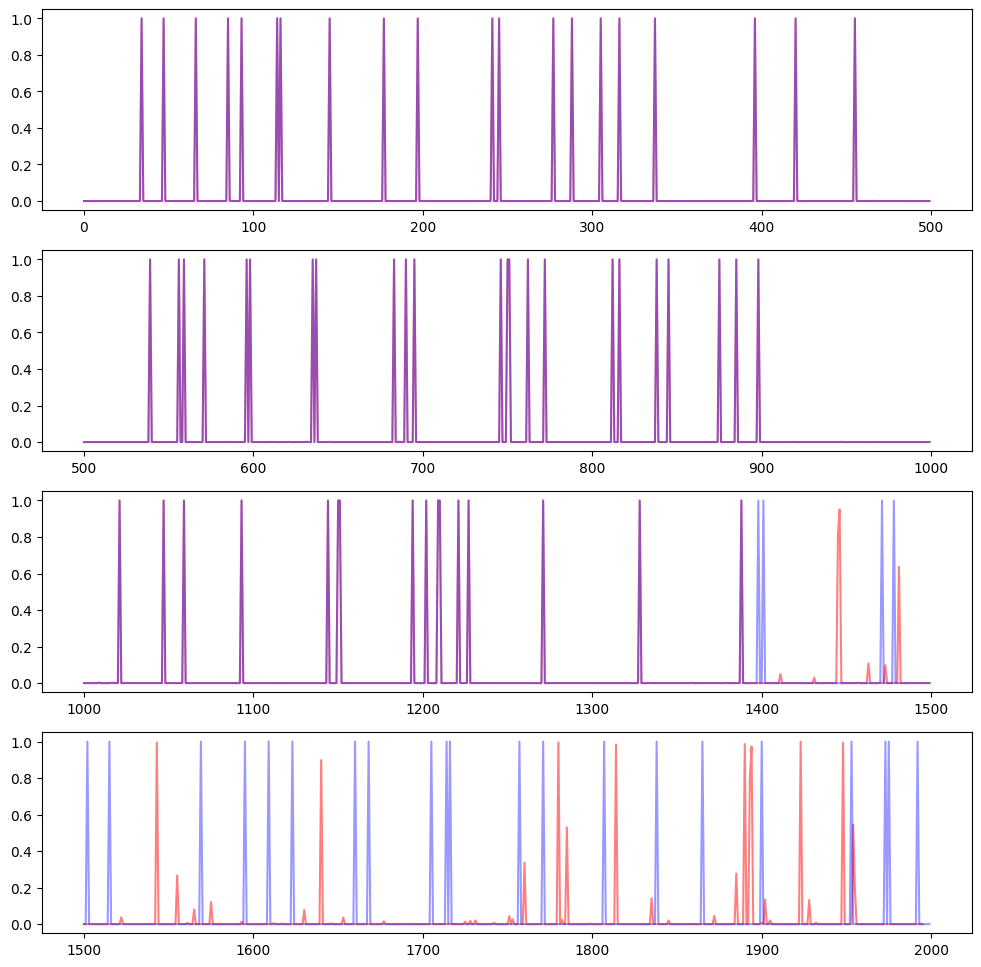

In [38]:
"""
plt.figure()
plt.plot(np.arange(train_result.shape[0]), train_result[:,2], c='red')
plt.plot(np.arange(target_train_df.shape[0]), target_train_df['states'], c='blue')
"""

print(changepoints)
print(np.where(np.round(all_pred_result[:,0]) >=1.0)[0] - int(WINDOW_WIDTH//2))
fig, axs = plt.subplots(T//500, 1, figsize=(12, 12))
for subplot_row in range(T//500):
    axs[subplot_row].plot(
        np.arange(min(1000, len(all_pred_result[:,0][subplot_row*500: subplot_row*500 + 500]))) + subplot_row*500,
        all_pred_result[:,0][subplot_row*500: subplot_row*500 + 500],
        c='red', alpha=0.5)
    axs[subplot_row].plot(
        np.arange(min(500, len(target_df['cps'][subplot_row*500: subplot_row*500 + 500]))) + subplot_row*500,
        target_df['cps'][subplot_row*500: subplot_row*500 + 500],
        c='blue', alpha=0.4)

In [ ]:
"""
plt.figure()
plt.plot(np.arange(train_result.shape[0]), train_result[:,2], c='red')
plt.plot(np.arange(target_train_df.shape[0]), target_train_df['states'], c='blue')
"""

print(changepoints)
print(np.where(np.round(all_pred_result[:,0]) >=1.0)[0] - int(WINDOW_WIDTH//2))
fig, axs = plt.subplots(T//500, 1, figsize=(12, 12))
for subplot_row in range(T//500):
    axs[subplot_row].plot(
        np.arange(min(1000, len(all_pred_result[:,0][subplot_row*500: subplot_row*500 + 500]))) + subplot_row*500,
        all_pred_result[:,0][subplot_row*500: subplot_row*500 + 500],
        c='red', alpha=0.5)
    axs[subplot_row].plot(
        np.arange(min(500, len(target_df['cps'][subplot_row*500: subplot_row*500 + 500]))) + subplot_row*500,
        target_df['cps'][subplot_row*500: subplot_row*500 + 500],
        c='blue', alpha=0.4)

In [ ]:
plt.figure()
plt.plot(np.arange(train_result.shape[0]), train_result[:,0], c='red')
plt.plot(np.arange(target_train_df.shape[0]), target_train_df['lb_diff_coefs'], c='blue')

plt.figure()
plt.plot(np.arange(train_result.shape[0]), train_result[:,1], c='red')
plt.plot(np.arange(target_train_df.shape[0]), target_train_df['alphas'], c='blue')

In [25]:
trajectory_object = trajectory_list[12]
trajectory_label = label_list[12]
msd = trajectory_object.get_msd(time_interval=TIME_INTERVAL)
diff_coefs = trajectory_object.get_diffusion_coefs(time_interval=TIME_INTERVAL)
angles = trajectory_object.get_trajectory_angles(time_interval=TIME_INTERVAL)

xs = trajectory_object.get_positions()[:,0]
ys = trajectory_object.get_positions()[:,1]
xs -= xs[0]
ys -= ys[0]

labeled_diff_coefs = trajectory_label[0]
labeled_alphas = trajectory_label[1]
labeled_states = trajectory_label[2]
labeled_cps = trajectory_label[3]

train_df = np.array([xs, ys, msd, diff_coefs, angles]).T
train_df = pd.DataFrame(train_df, columns=['xs', 'ys', 'msd', 'diff_coefs', 'angles'])
target_df = np.array([labeled_diff_coefs, labeled_alphas, labeled_states, labeled_cps]).T
target_df = pd.DataFrame(target_df, columns=['lb_diff_coefs', 'alphas', 'states', 'cps'])

test_ = make_prediction_set(train_df, WINDOW_WIDTH)
test_result = residual_lstm.predict(test_)

6/6 [==============================] - 1s 151ms/step


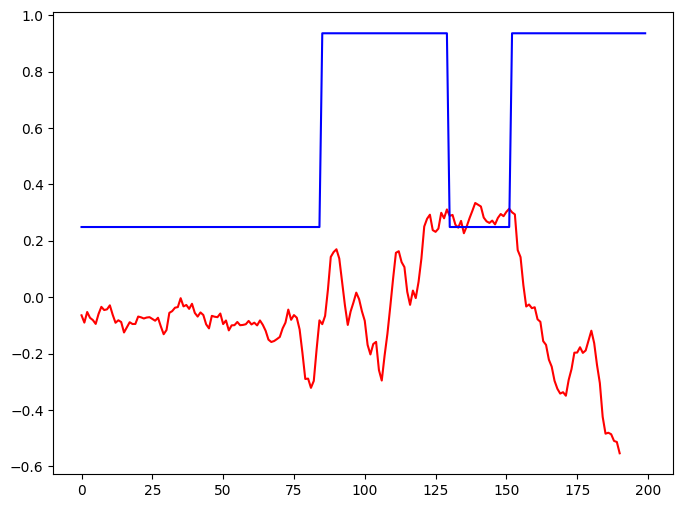

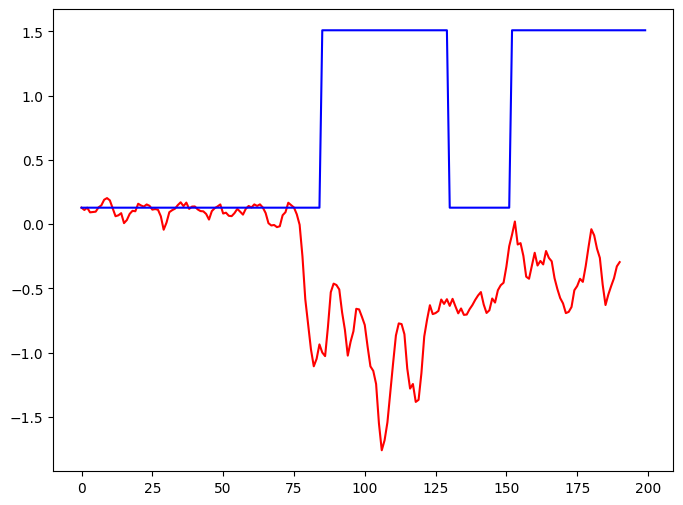

In [26]:
plt.figure()
plt.plot(np.arange(test_result.shape[0]), test_result[:,0], c='red')
plt.plot(np.arange(target_df.shape[0]), target_df['lb_diff_coefs'], c='blue')

plt.figure()
plt.plot(np.arange(test_result.shape[0]), test_result[:,1], c='red')
plt.plot(np.arange(target_df.shape[0]), target_df['alphas'], c='blue')